In [186]:
import os
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from category_encoders import JamesSteinEncoder #not sure if using
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, metrics
import pandas as pd
from sklearn import datasets

In [187]:
styles = pd.read_csv("data/styles.csv",on_bad_lines='skip')
styles.head()
styles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [188]:

styles = styles[styles['articleType'] != 'Free Gifts']
styles[styles['articleType']=='Free Gifts'].head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName


In [189]:
# Create a new column with full image file paths
styles['image_path'] = styles['id'].apply(lambda x: os.path.join("data\\images", f"{x}.jpg"))
styles = styles[styles['image_path'].apply(os.path.exists)]
print (len(styles))
# Check the result
print(styles[['id', 'image_path']].head())

20462
      id             image_path
0  15970  data\images\15970.jpg
3  21379  data\images\21379.jpg
5   1855   data\images\1855.jpg
6  30805  data\images\30805.jpg
7  26960  data\images\26960.jpg


In [190]:
# DATA CLEANING

from category_encoders import JamesSteinEncoder

styles['productDisplayName'] = styles['productDisplayName'].fillna('Unknown Product')
usage_mode = styles['usage'].mode()[0]
styles['usage'] = styles['usage'].fillna(usage_mode)
color_mode = styles['baseColour'].mode()[0]

# Fill missing values
styles['baseColour'] = styles['baseColour'].fillna(color_mode)

styles.isnull().sum()


id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
image_path            0
dtype: int64

In [191]:
styles.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,data\images\15970.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,data\images\21379.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,data\images\1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt,data\images\30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt,data\images\26960.jpg


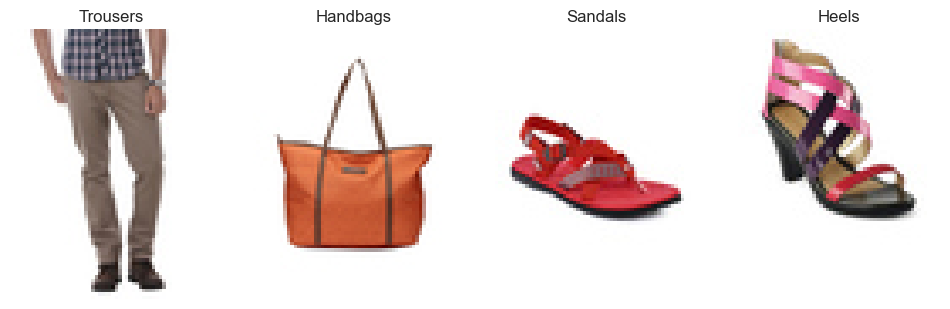

In [192]:
from PIL import Image

# Display the first image
#img = Image.open(styles.iloc[0]['image_path'])
#img.show()


# Choose 4 random rows
sample = styles.sample(4)

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for ax, (_, row) in zip(axes, sample.iterrows()):
    image = Image.open(row['image_path']).convert('RGB')
    ax.set_axis_off()
    ax.imshow(image)
    ax.set_title(row['articleType'])  # or use subCategory, gender, etc.



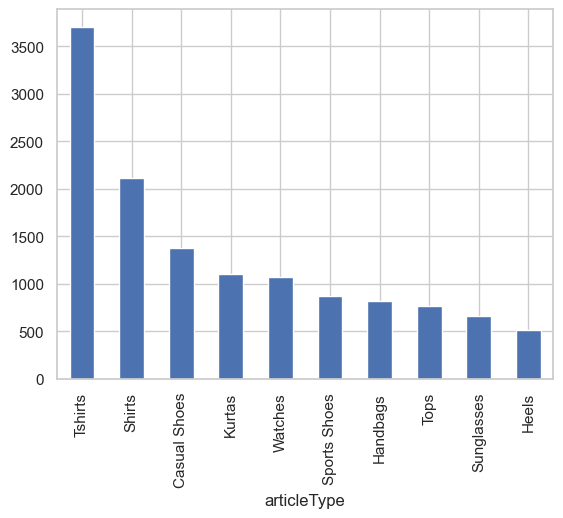

In [193]:
styles["articleType"].value_counts().nlargest(10).plot(kind='bar')

plt.show()

In [194]:
IMAGE_SIZE = (64, 64)

def preprocess_image(path):
    img = Image.open(path).convert('L').resize(IMAGE_SIZE)
    return np.array(img).flatten()  # Shape: (4096,)

# Flatten all images
X = np.array([preprocess_image(p) for p in styles['image_path']])


In [196]:
# Create a classifier: a knn classifier to test
clf = KNeighborsClassifier()

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
   X, styles['articleType'], test_size=0.2, shuffle=False
)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)
print (y_test)
print (predicted)
test_accuracy = clf.score(X_test, y_test)
print("Accuracy:", test_accuracy)

35565           Heels
35566    Casual Shoes
35568            Tops
35569        Handbags
35571         Wallets
             ...     
44414         Tshirts
44415         Tshirts
44417         Tshirts
44419    Casual Shoes
44421         Tshirts
Name: articleType, Length: 4093, dtype: object
['Casual Shoes' 'Casual Shoes' 'Tops' ... 'Tops' 'Casual Shoes' 'Tshirts']
Accuracy: 0.7500610798924994


In [197]:
# Print out the actual and predicted values
for i, (true, pred) in enumerate(zip(y_test.values, predicted)):
    if i == 10:
        break
    print(f"Actual: {true} — Predicted: {pred}")

Actual: Heels — Predicted: Casual Shoes
Actual: Casual Shoes — Predicted: Casual Shoes
Actual: Tops — Predicted: Tops
Actual: Handbags — Predicted: Handbags
Actual: Wallets — Predicted: Wallets
Actual: Tshirts — Predicted: Tshirts
Actual: Tshirts — Predicted: Shirts
Actual: Tshirts — Predicted: Tshirts
Actual: Kurtas — Predicted: Kurtas
Actual: Sweatshirts — Predicted: Shirts


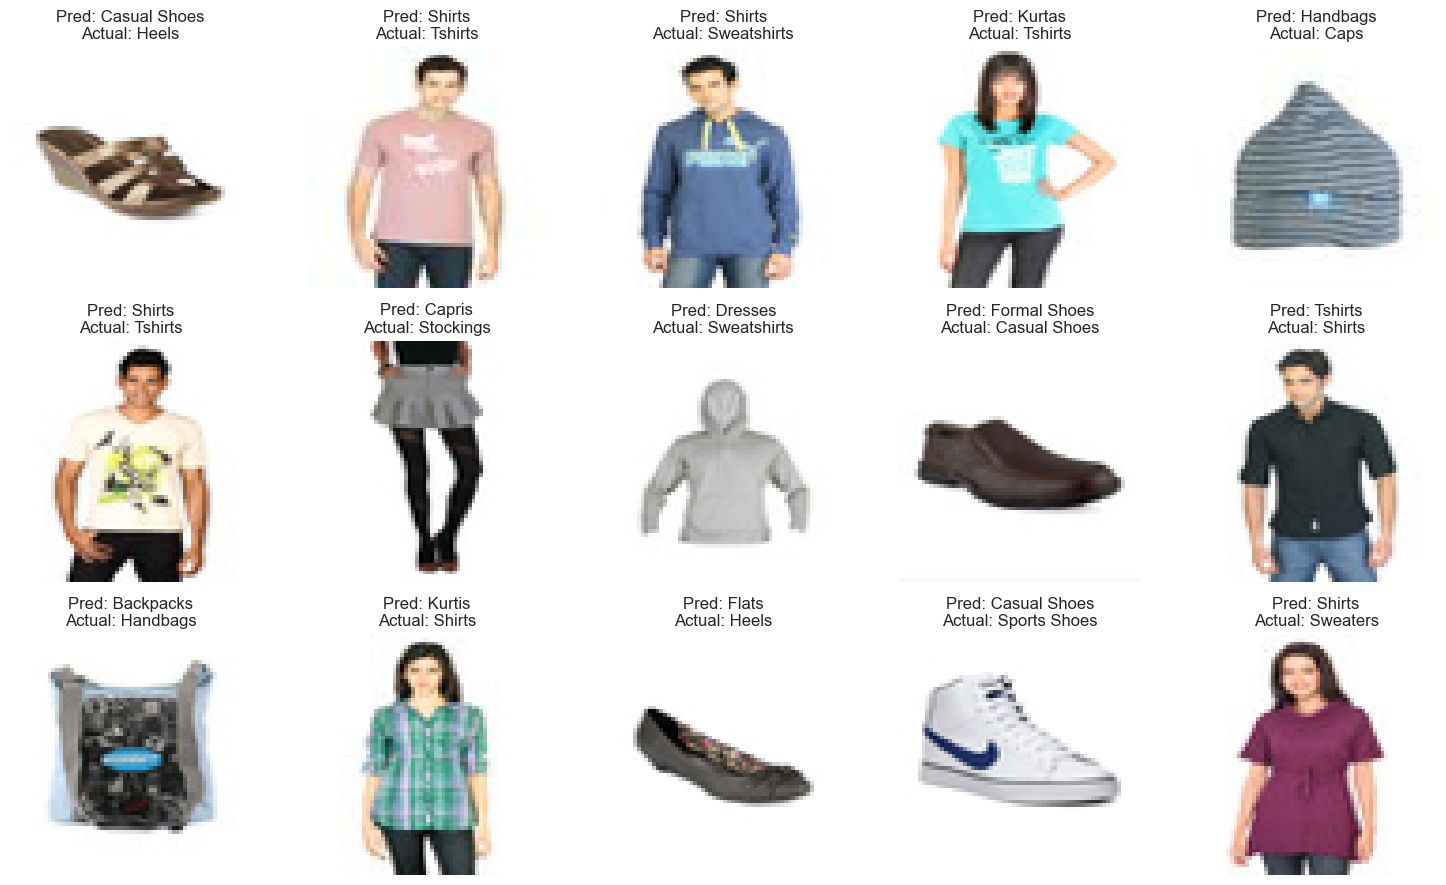

In [198]:
import matplotlib.pyplot as plt
import math

# Get the test set image paths
test_paths = styles.loc[y_test.index, 'image_path'].values  # ✅

# Loop through and show incorrect predictions
wrong = [(i, p, a) for i, (p, a) in enumerate(zip(predicted, y_test.values)) if p != a]
#Number of images you want to show
show_num = 15  # for example

# Set number of columns (images per row)
cols = 5
rows = math.ceil(show_num / cols)

plt.figure(figsize=(3 * cols, 3 * rows))  # adjust size as needed

# View the images of the incorrectly categorized data
for i, (idx, pred, actual) in enumerate(wrong[:show_num]):
    img = Image.open(test_paths[idx]).resize((64, 64))
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Pred: {pred}\nActual: {actual}')

plt.tight_layout()
plt.show()

In [199]:
#Try multiple models to see what works

In [200]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

# define the models
models = {
    'kNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(
            max_depth=10,          # Prevents overfitting; try values like 5–20
            min_samples_split=10,  # Minimum samples to split an internal node
            min_samples_leaf=5,    # Minimum samples required at a leaf node
            max_features='sqrt',   # Consider a subset of features at each split
            criterion='entropy',   # Try 'entropy' (information gain) vs. default 'gini'
            random_state=42        # For reproducibility
        )
    #'SVM': SVC() #takes too long
}


    # Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
   X, styles['articleType'], test_size=0.2, shuffle=False
)
for name, model in models.items():
    # Create a classifier: a support vector classifier
    clf = model
    
    # Learn the digits on the train subset
    clf.fit(X_train, y_train)
    
    # Predict the value of the digit on the test subset
    train_predicted = clf.predict(X_train)
    predicted = clf.predict(X_test)
    #print (y_test)
    #print (predicted)
    train_accuracy = clf.score(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print(name + " Train Accuracy:", train_accuracy)
    print(name + " Test Accuracy:", accuracy)
    

kNN Train Accuracy: 0.8327326043130308
kNN Test Accuracy: 0.7500610798924994


C:\Users\lorig\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Train Accuracy: 0.7364530514997861
Logistic Regression Test Accuracy: 0.718299535792817
Decision Tree Train Accuracy: 0.7344370456350419
Decision Tree Test Accuracy: 0.6618617151233814


C:\Users\lorig\AppData\Local\Temp\ipykernel_63008\1856849906.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Model', y='Accuracy', palette='pastel')


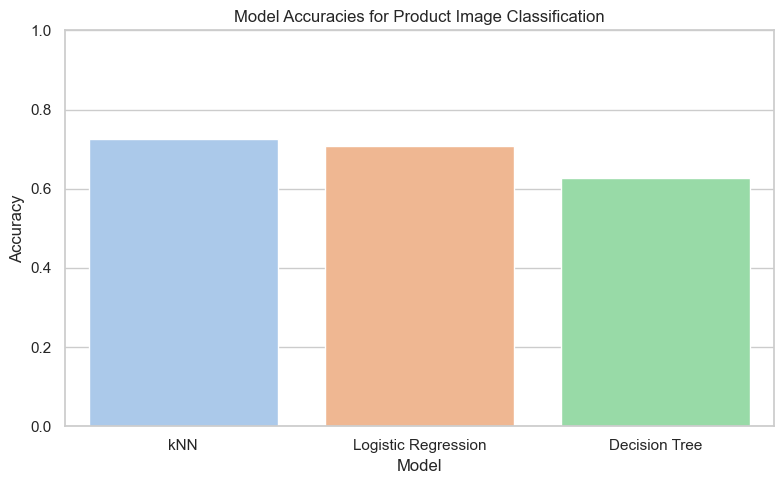

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Model accuracies
model_accuracies = {
    'kNN': 0.7251781704578737,
    'Logistic Regression': 0.7078980767353314,
    'Decision Tree': 0.6275505223079176
}

# Convert to DataFrame
df = pd.DataFrame(list(model_accuracies.items()), columns=['Model', 'Accuracy'])

# Seaborn barplot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='Model', y='Accuracy', palette='pastel')
plt.ylim(0, 1)
plt.title('Model Accuracies for Product Image Classification')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.tight_layout()
plt.savefig('images/initial_model_accuracies.png', dpi=300, bbox_inches='tight')
plt.show()

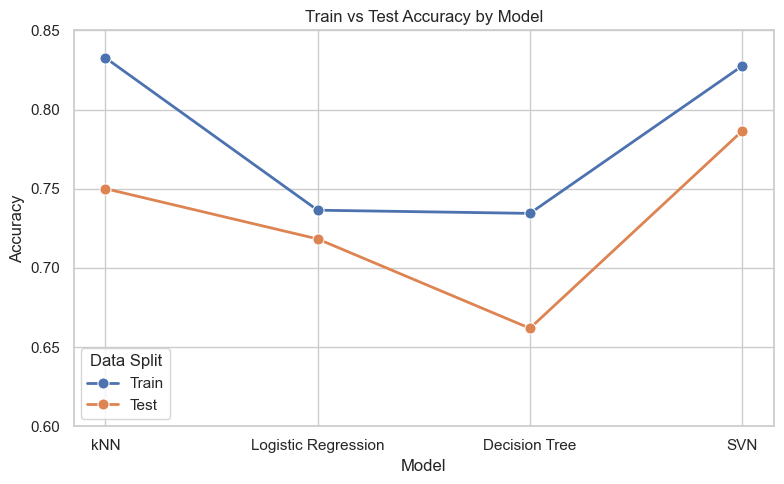

In [202]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Accuracy data
#SCV Train Accuracy : 0.8275398619341439
#SCV Test Accuracy : 0.7864646958221354
data = {
    'Model': ['kNN', 'kNN', 'Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Decision Tree', 'SVN', 'SVN'],
    'Set': ['Train', 'Test'] * 4,
    'Accuracy': [
        0.8327326043130308, 0.7500610798924994,  # kNN
        0.7364530514997861, 0.718299535792817,   # Logistic Regression
        0.7344370456350419, 0.6618617151233814,   # Decision Tree
        0.8275398619341439, 0.7864646958221354   #SVN with Decomposition
    ]
}

df = pd.DataFrame(data)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Line + dot plot
sns.lineplot(data=df, x="Model", y="Accuracy", hue="Set", marker='o', linewidth=2, markersize=8)

plt.ylim(0.6, 0.85)
plt.title("Train vs Test Accuracy by Model")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.legend(title="Data Split")
plt.tight_layout()
plt.savefig("images/test_train_acc.png")
plt.show()

In [203]:
#Using PCA to take the image data to 100 components instead of over 24,000
#This greatly helped computation times.

In [204]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

svm = SVC()
svm.fit(X_train_reduced, y_train)

SVC()

In [205]:
svm_train_accuracy = svm.score(X_train_reduced, y_train)
svm_test_accuracy = svm.score(X_test_reduced, y_test)
print ("SVM Train Accuracy : " + str(svm_train_accuracy))
print ("SVM Test Accuracy : " + str(svm_test_accuracy))

SVM Train Accuracy : 0.8273565886737125
SVM Test Accuracy : 0.7879306132421207


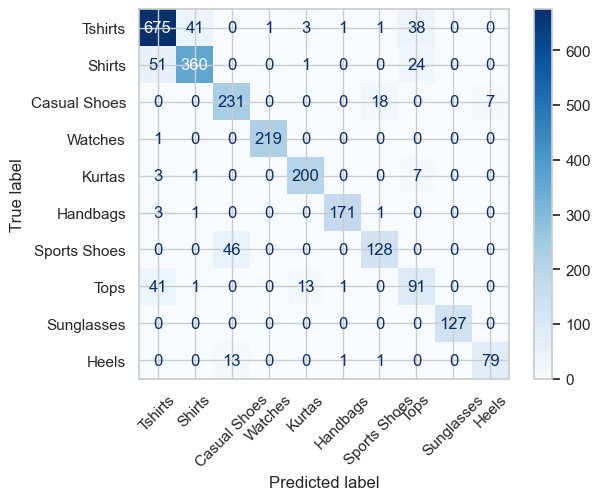

In [206]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

top_classes = y_test.value_counts().nlargest(10).index

# Filter y_test and y_pred to only include these
mask = y_test.isin(top_classes)
filtered_y_test = y_test[mask]
filtered_y_pred = pd.Series(y_pred, index=y_test.index)[mask]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(filtered_y_test, filtered_y_pred, labels=top_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=top_classes)
disp.plot(cmap='Blues', xticks_rotation=45)

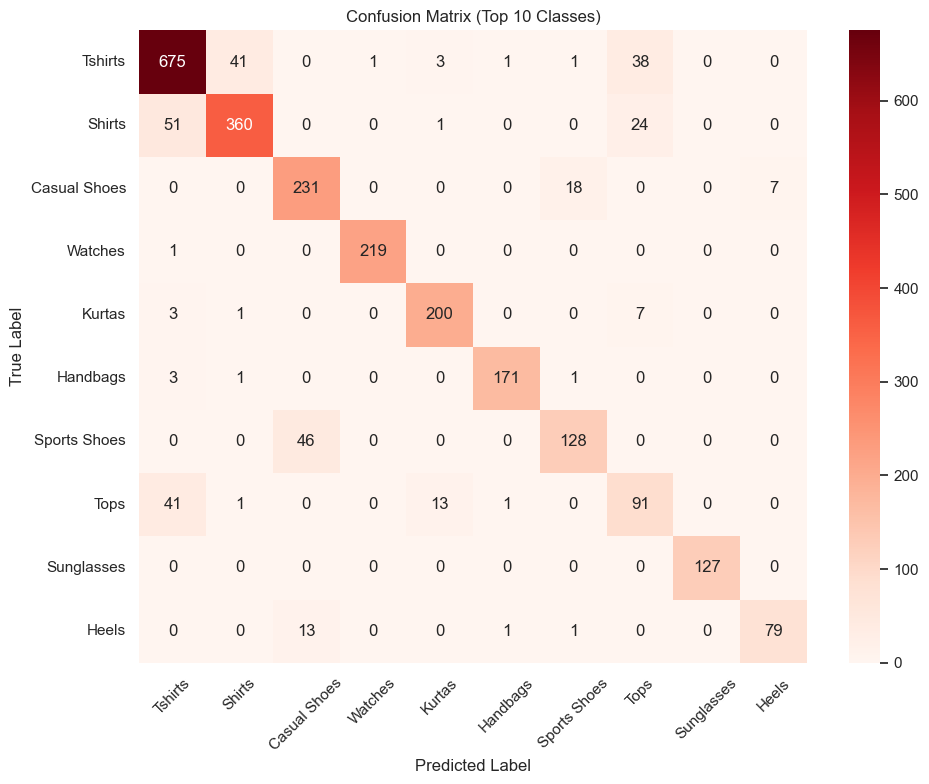

In [207]:
#Step 3: Turn it into a DataFrame for Seaborn
cm_df = pd.DataFrame(cm, index=top_classes, columns=top_classes)

# Step 4: Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Reds', cbar=True)
plt.title('Confusion Matrix (Top 10 Classes)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("images/heatmap.png")
plt.show()